In [1]:
import torch
import torchvision
from PIL import Image
from torchvision import transforms
import os, random
import pandas as pd
from operator import itemgetter
%load_ext autoreload
%autoreload 2
import peek_in as peek
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

myblue = [46/255, 125/255, 158/255]
myyellow = [241/255, 193/255, 109/255]
myred = [229/255, 120/255, 114/255]
mygray = [150/255, 150/255, 150/255]
# my_palette = [myyellow, mygray, myred, myblue]
my_palette = [myred, myblue]

matplotlib.rcParams['hatch.linewidth'] = 4.0
sns.set(font_scale = 2.0)
sns.set_style('white')

def compute_similarity(model):
    ntrials = 100 
    df = pd.DataFrame(columns=['condition', 'trial', 'images', 'layer', 'similarity'])

    for folder_pair in itemgetter(0,1,2,3)(params['folder_pairs']): # Each folder pair is a condition
        condition = folder_pair[0]
        fold1 = folder_pair[1]
        fold2 = folder_pair[2]

        # During each trial, pick two files randomly and get the cosine distances of their embeddings
        for triali in range(ntrials):
            # Randomly choose two files, one from each folder
            im1 = random.choice(os.listdir(fold1)) 
            im2 = random.choice(os.listdir(fold2)) 
            full_im1 = os.path.join(fold1, im1)
            full_im2 = os.path.join(fold2, im2)
            imp = [full_im1, full_im2]
            # print(imp)

            # Get transformed tensors from image files
            stim1, stim2 = peek.stim_from_pair(imp, device)

            # Run forward pass on first stimulus and get embeddings
            embed1, handles1 = peek.hook_embeddings(model)
            out = model(stim1)
            for handle in handles1:
                handle.remove() # Detach our copy (embeddings) from the layers

            # Run forward pass on second stimulus and get embeddings
            embed2, handles2 = peek.hook_embeddings(model)
            out = model(stim2)
            for handle in handles2:
                handle.remove() # Detach our copy (embeddings) from the layers

            # Visualise a layer's activation in response to stimulus
            # peek.visualise_embedding(embed1, 10)
            # peek.visualise_embedding(embed2, 10)

            # Get respective cosine distances between the layers
            cosine_dists_triali = peek.get_cosine_dists(embed1, embed2)
            for ii in range(len(cosine_dists_triali)):
                df = df.append({'condition': condition, 'trial': triali+1,'images': imp,\
                                'layer': cosine_dists_triali[ii][0], 'similarity': cosine_dists_triali[ii][1]},\
                            ignore_index=True)

    return(df)
    print(df)


def visualise_cosine_sim(df, model_name, experiment):
    # Visualise distances
    if model_name == 'vgg16':
        mapping = {'0: Conv2d': 0, '1: Conv2d': 1, '2: Conv2d': 2, '3: Conv2d': 3, '4: Conv2d': 4, '5: Conv2d': 5,
            '6: Conv2d': 6, '7: Conv2d': 7, '8: Conv2d': 8, '9: Conv2d': 9, '10: Conv2d': 10, '10: Conv2d': 10,
            '11: Conv2d': 11, '12: Conv2d': 12, '13: GPool': 13, '14: Linear': 14, '15: Linear': 15, '16: Linear': 16} 
    elif model_name == 'alexnet':
        mapping = {'0: Conv2d': 0, '1: Conv2d': 1, '2: Conv2d': 2, '3: Conv2d': 3, '4: Conv2d': 4,
            '5: GPool': 5, '6: Linear': 6, '7: Linear': 7, '8: Linear': 8} 
    upper_df = df.loc[df['condition'] == 'Ba-Ba (Same)']
    upper_df.replace({'layer': mapping}, inplace=True)
    mean_upper = upper_df.groupby('layer').mean()['similarity'].to_numpy()
    lower_df = df.loc[df['condition'] == 'Ba-Ba (Diff)']
    lower_df.replace({'layer': mapping}, inplace=True)
    mean_lower = lower_df.groupby('layer').mean()['similarity'].to_numpy()
    if experiment == 'hs96':
        rel_cod_df = df.loc[(df['condition'] == 'Ba-Rel') | (df['condition'] == 'Ba-Cod')]
    elif experiment == 'polygons':
        rel_cod_df = df.loc[(df['condition'] == 'Ba-Sh') | (df['condition'] == 'Ba-Rot')]

    myfig, myax = plt.subplots(figsize=(14,9))
    plt.fill_between(np.arange(0,len(mean_lower)), mean_upper, mean_lower, color=myyellow, ec='white', hatch='//', alpha=0.8)
    plot_handle = sns.lineplot(x='layer', y='similarity', hue='condition', style='condition', lw=8.0,
        palette=my_palette, alpha=0.8, data=rel_cod_df, ax=myax)
    plot_handle.set(xlabel='Layer', ylabel='Similarity')
    plot_handle.set(ylim=(0,1))
    # plot_handle.lines[2].set_linestyle("--")
    # plot_handle.lines[3].set_linestyle("--")
    plot_handle.yaxis.labelpad = 15 
    plot_handle.xaxis.labelpad = 15 
    leg = plt.legend(loc='upper left')
    for legobj in leg.legendHandles:
        legobj.set_linewidth(6.0)
        legobj._legmarker.set_markersize(15)
    for item in plot_handle.get_xticklabels():
        item.set_rotation(90)

# Train on HS96

Network pre-trained on Imagenet, then trained on HS96 (learning in all layers) and tested on four conditions:
- **Ba-Ba (Same)**: Cosine similarity between two Basis images from same category
- **Ba-Ba (Diff)**: Cosine similarity between two Basis images from different category
- **Ba-Rel**: Cosine similarity between a Basis image and a Relational deformation of that image (random translation, rotation and scale)
- **Ba-Cod**: Cosine similarity between a Basis image and a Coordinate transform of that image (random translation, rotation and scale)

In each case, **50 images** are randomly selected from a category and compared (cosine similarity) with embeddings of 50 other randomly selected images.

In [2]:
params = {'model': 'alexnet', # 'alexnet'
          'folder_pairs': [('Ba-Ba (Same)', './data/orig/test_b/1', './data/orig/test_b/1'),
                           ('Ba-Ba (Diff)', './data/orig/test_b/1', './data/orig/test_b/2'),
                           ('Ba-Rel', './data/orig/test_b/1', './data/orig/test_v1/1'),
                           ('Ba-Cod', './data/orig/test_b/1', './data/orig/test_v2/1')]}

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
if params['model'] == 'vgg16':
    model = torch.load('./data/orig/train/trained_model_vgg.pt')
elif params['model'] == 'alexnet':
    model = torch.load('./data/orig/train/trained_model_alexnet.pt')
model = model.to(device)
model.eval() # Set model to eval mode (no dropout, etc)
;

''

In [3]:
data = compute_similarity(model=model)

/home/gaurav/miniconda3/envs/lab2020/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


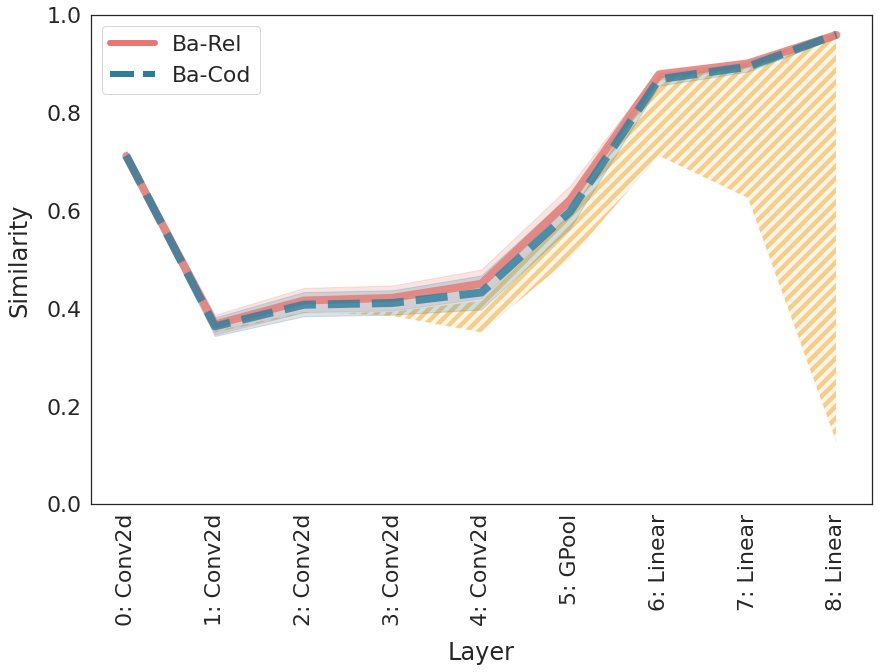

In [4]:
visualise_cosine_sim(df=data, model_name=params['model'], experiment='hs96')

# Train on HS96 and Relations

Network pre-trained on Imagenet, then trained on HS96+Rel transforms of 5 out of 6 shapes (to teach the network that relations matter) and tested on four conditions:
- **Ba-Ba (Same)**: Cosine similarity between two Basis images from same category
- **Ba-Ba (Diff)**: Cosine similarity between two Basis images from different category (in fact, this _different_ category is the relational (v1) transform of the first category)
- **Ba-Rel**: Cosine similarity between a Basis image and a Relational transform of that image (for the sixth shape where Relational transform was not trained)
- **Ba-Cod**: Cosine similarity between a Basis image and a Cod transform of that image (again for the sixth shape)

Note that categories 1--10 are trained in pairs (category 6 is Rel transform of category 1, etc.), but category 11 does not have a pair. Therefore the test conditions Ba-Rel and Ba-Cod are conducted on category 11.

In each case, **100 images** are randomly selected from a category and compared (cosine similarity) with embeddings of 50 other randomly selected images.

In [8]:
params = {'model': 'alexnet', # 'vgg16' / 'alexnet'
          'folder_pairs': [('Ba-Ba (Same)', './data/teach_v1_new/test_b/1', './data/teach_v1_new/test_b/1'),
                           ('Ba-Ba (Diff)', './data/teach_v1_new/test_b/1', './data/teach_v1_new/test_b/6'),
                           ('Ba-Rel', './data/teach_v1_new/test_b/11', './data/teach_v1_new/test_v1/11'),
                           ('Ba-Cod', './data/teach_v1_new/test_b/11', './data/teach_v1_new/test_v2/11')]}

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
if params['model'] == 'vgg16':
    model = torch.load('./data/teach_v1_new/train/trained_model_vgg.pt')
elif params['model'] == 'alexnet':
    model = torch.load('./data/teach_v1_new/train/trained_model_alexnet.pt')
model = model.to(device)
model.eval() # Set model to eval mode (no dropout, etc)
;

''

In [9]:
data = compute_similarity(model=model)

/home/gaurav/miniconda3/envs/lab2020/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


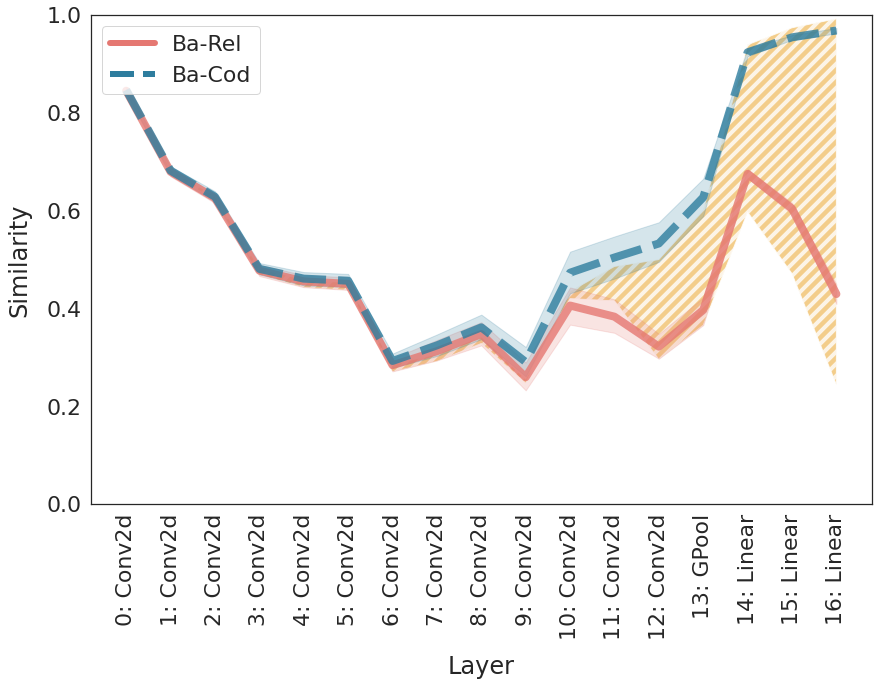

In [10]:
visualise_cosine_sim(df=data, model_name=params['model'], experiment='hs96')

# Train on HS96 and Relations - but exclude the exact relational change

_Same as above, except the basis set replaces categories 4&9 with stimuli that does not change vertical bar on the left_

Does learning on one relational change mean that the network generalises to other relational changes?

Network pre-trained on Imagenet, then trained on HS96+Rel transforms of 5 out of 6 shapes (to teach the network that relations matter) and tested on four conditions:
- **Ba-Ba (Same)**: Cosine similarity between two Basis images from same category
- **Ba-Ba (Diff)**: Cosine similarity between two Basis images from different category (in fact, this _different_ category is the relational (v1) transform of the first category)
- **Ba-Rel**: Cosine similarity between a Basis image and a Relational transform of that image (for the sixth shape where Relational transform was not trained)
- **Ba-Cod**: Cosine similarity between a Basis image and a Coordinate transform of that image (again for the sixth shape)

Note that categories 1--10 are trained in pairs (category 6 is Rel transform of category 1, etc.), but category 11 does not have a pair. Therefore the test conditions Ba-Rel and Ba-Cod are conducted on category 11.

In each case, **100 images** are randomly selected from a category and compared (cosine similarity) with embeddings of 50 other randomly selected images.

In [36]:
params = {'model': 'alexnet', # 'vgg16' / 'alexnet'
          'folder_pairs': [('Ba-Ba (Same)', './data/teach_v1_exclude_exact/test_b/1', './data/teach_v1_exclude_exact/test_b/1'),
                           ('Ba-Ba (Diff)', './data/teach_v1_exclude_exact/test_b/1', './data/teach_v1_exclude_exact/test_b/6'),
                           ('Ba-Rel', './data/teach_v1_exclude_exact/test_b/11', './data/teach_v1_exclude_exact/test_v1/11'),
                           ('Ba-Cod', './data/teach_v1_exclude_exact/test_b/11', './data/teach_v1_exclude_exact/test_v2/11')]}

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
if params['model'] == 'vgg16':
    model = torch.load('./data/teach_v1_exclude_exact/train/trained_model_vgg.pt')
elif params['model'] == 'alexnet':
    model = torch.load('./data/teach_v1_exclude_exact/train/trained_model_alexnet.pt')
model = model.to(device)
model.eval() # Set model to eval mode (no dropout, etc)
;

''

In [13]:
data = compute_similarity(model=model)

In [ ]:
visualise_cosine_sim(df=data, model_name=params['model'], experiment='hs96')

# Train on HS96 and Relations - but exclude relational changes on the left

_Same as above, except the basis set does not contain **any** stimuli that changes relations on the left_

Does learning on relational changes on one side generalise to the other side? Is the network really learning about relations or just some local features that are important for category change?

Network pre-trained on Imagenet, then trained on HS96+V1 transforms of 5 out of 6 shapes (to teach the network that relations matter) and tested on four conditions:
- **Ba-Ba (Same)**: Cosine similarity between two Basis images from same category
- **Ba-Ba (Diff)**: Cosine similarity between two Basis images from different category (in fact, this _different_ category is the relational (v1) transform of the first category)
- **Ba-Rel**: Cosine similarity between a Basis image and a Relational transform of that image (for the sixth shape where Relational transform was not trained)
- **Ba-Cod**: Cosine similarity between a Basis image and a Coordinate transform of that image (again for the sixth shape)

Note that categories 1--10 are trained in pairs (category 6 is Relational transform of category 1, etc.), but category 11 does not have a pair. Therefore the test conditions Ba-Rel and Ba-Cod are conducted on category 11.

In each case, **100 images** are randomly selected from a category and compared (cosine similarity) with embeddings of 50 other randomly selected images.

In [15]:
params = {'model': 'vgg16', # 'vgg16' / 'alexnet'
          'folder_pairs': [('Ba-Ba (Same)', './data/teach_v1_exclude_left/test_b/1', './data/teach_v1_exclude_left/test_b/1'),
                           ('Ba-Ba (Diff)', './data/teach_v1_exclude_left/test_b/1', './data/teach_v1_exclude_left/test_b/6'),
                           ('Ba-Rel', './data/teach_v1_exclude_left/test_b/11', './data/teach_v1_exclude_left/test_v1/11'),
                           ('Ba-Cod', './data/teach_v1_exclude_left/test_b/11', './data/teach_v1_exclude_left/test_v2/11')]}

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
if params['model'] == 'vgg16':
    model = torch.load('./data/teach_v1_exclude_left/train/trained_model_vgg.pt')
elif params['model'] == 'alexnet':
    model = torch.load('./data/teach_v1_exclude_left/train/trained_model_alexnet.pt')
model = model.to(device)
model.eval() # Set model to eval mode (no dropout, etc)
;

''

In [22]:
data = compute_similarity(model=model)

In [ ]:
visualise_cosine_sim(df=data, model_name=params['model'], experiment='hs96')

# Train on Polygons

Network pre-trained on Imagenet, then trained on Polygons (conv layers frozen) and tested on four conditions:
- **Up-Up (Same)**: Cosine similarity between two Upright (basis) images from same category
- **Up-Up (Diff)**: Cosine similarity between two Upright (basis) images from different categories
- **Up-Sh**: Cosine similarity between an upright image and a sheared image from same category
- **Up-Rot**: Cosine similarity between an upright image and a rotated image from same category

In each case, **100 images** are randomly selected from a category and compared (cosine similarity) with embeddings of 100 other randomly selected images.

In [34]:
params = {'model': 'alexnet', # 'vgg16_rot_shear', 'alexnet'
          'folder_pairs': [('Ba-Ba (Same)', './data/isostim/testgrid/2/sh_1/dist_1/2', './data/isostim/testgrid/2/sh_1/dist_1/2'),
                           ('Ba-Ba (Diff)', './data/isostim/testgrid/2/sh_1/dist_1/2', './data/isostim/testgrid/5/sh_1/dist_1/5'),
                           ('Ba-Sh', './data/isostim/testgrid/2/sh_1/dist_1/2', './data/isostim/testgrid/2/sh_6/dist_1/2'),
                           ('Ba-Rot', './data/isostim/testgrid/2/sh_1/dist_1/2', './data/isostim/testgrid/2/sh_1/dist_6/2')]}

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
if params['model'] == 'vgg16':
    model = torch.load('./data/isostim/train/vgg_trained_model_learnall.pt')
elif params['model'] == 'alexnet':
    model = torch.load('./data/isostim/train/alexnet_trained_model_learnall.pt')
elif params['model'] == 'vgg16_rot_shear':
    model = torch.load('./data/isostim_train_rots_shears/train/trained_model_onlyclass.pt')
model = model.to(device)
model.eval() # Set model to eval mode (no dropout, etc)
;

''

In [35]:
data = compute_similarity(model=model)

/home/gaurav/miniconda3/envs/lab2020/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


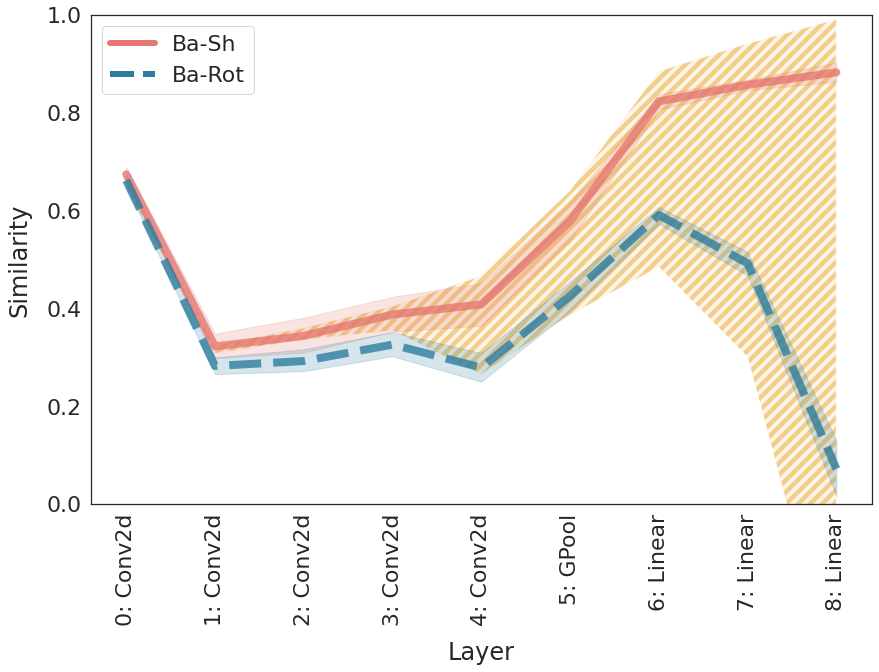

In [36]:
visualise_cosine_sim(df=data, model_name=params['model'], experiment='polygons')